# Imports

In [1]:
import warnings
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.functions import CorrClass as cs
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = 12,40

cs = cs()

# Set rules

In [2]:
MIN_ADD = datetime.timedelta(seconds = 60)
HOUR_ADD = 60 * MIN_ADD
DAY_ADD = HOUR_ADD * 24 

# Get data

In [3]:
dfMarketData = pd.read_csv('WDODATA.csv','\t')
dfMarketData.columns = ['Date','Time','Open','High','Low','Close','TickVol','Vol','Spread']
dfMarketData['Datetime'] = dfMarketData['Date'].str.replace('.','-') + ' ' + dfMarketData['Time']
dfMarketData = dfMarketData[['Datetime','Open','High','Low','Close']]
dfMarketData['Datetime'] = pd.to_datetime(dfMarketData['Datetime'])
dfMarketData = dfMarketData.set_index('Datetime')
dfMarketData = dfMarketData.sort_index()

In [4]:
dfEventsData = pd.read_csv('EventsData.csv')
dfEventsFromTo = pd.read_csv('EventsFromTo.csv')
dfEventsFromTo=dfEventsFromTo.set_index('EventID').T
dfEventsData['ReleaseTime'] = pd.to_datetime(dfEventsData['ReleaseTime'])
dfEventsData['PercentChng'] = dfEventsData['ActualValue']/dfEventsData['PreviousValue']-1
dfEventsData['Date'] = dfEventsData['ReleaseTime'].apply(lambda x: datetime.datetime.strptime(str(x).split(' ')[0], '%Y-%m-%d'))
dfEventsData = dfEventsData.loc[dfEventsData['ReleaseTime'] > min(dfMarketData.index),:]
dfEventsData['ReleaseTime'] = pd.to_datetime(dfEventsData['ReleaseTime'])
dfEventsData = dfEventsData.set_index('ReleaseTime')
dfEventsData = dfEventsData.sort_index()

# Split train/test

In [5]:
dfEventsDataTrain=dfEventsData[dfEventsData.index<=datetime.datetime.combine(dfEventsData.iloc[int(.7*len(dfEventsData)),:]['Date'], datetime.datetime.min.time())]
dfEventsDataTest=dfEventsData[dfEventsData.index>datetime.datetime.combine(dfEventsData.iloc[int(.7*len(dfEventsData)),:]['Date'], datetime.datetime.min.time())]
dfMarketDataTrain=dfMarketData.loc[dfMarketData.index<datetime.datetime.combine(max(dfEventsDataTrain.index).date(), datetime.datetime.min.time())+DAY_ADD]
dfMarketDataTest=dfMarketData[dfMarketData.index>=datetime.datetime.combine(max(dfMarketDataTrain.index).date(), datetime.datetime.min.time())]

# Calculate variation after releases

In [6]:
def variationRatio(
    dfEventsData,
    dfMarketData
) -> pd.DataFrame():
    df = pd.DataFrame()
    for idx, release in dfEventsData.iterrows():
        mktdata_on_release = idx
        mktdata_after_release = mktdata_on_release + MIN_ADD * 5
        mktdata_pre_release = mktdata_on_release - MIN_ADD * 5
        df_mktdata_release = dfMarketData[(dfMarketData.index >= mktdata_on_release) & (dfMarketData.index <= mktdata_after_release)]
        df_mktdata_pre_release = dfMarketData[(dfMarketData.index <= mktdata_on_release) & (dfMarketData.index >= mktdata_pre_release)]
        if not df_mktdata_release.empty and not df_mktdata_pre_release.empty:
            release_price = -1
            try:
                release_price = df_mktdata_release['Open'][mktdata_on_release]
            except:
                try:
                    release_price = df_mktdata_release['Close'][mktdata_on_release - MIN_ADD]
                except:
                    continue
            variation_after_release = max(abs(release_price-max(df_mktdata_release['High'])),abs(release_price-min(df_mktdata_release['Low'])))
            variation_pre_release = max(abs(release_price-max(df_mktdata_pre_release['High'])),abs(release_price-min(df_mktdata_pre_release['Low'])))
            variation_diff = variation_after_release/variation_pre_release-1
            df = df.append(
                {
                    'EventID': dfEventsFromTo[int(release['EventID'])]['EventName'],
                    'Ratio': variation_diff
                }, ignore_index=True 
            )
    dict_data = {}
    for idx, data in df.iterrows():
        if data['EventID'] in dict_data.keys():
            dict_data[data['EventID']].append(data['Ratio'])
        else:
            dict_data[data['EventID']]=[data['Ratio']]
    df = pd.DataFrame.from_dict(dict_data, orient='index')
    df = df.transpose()
    return df

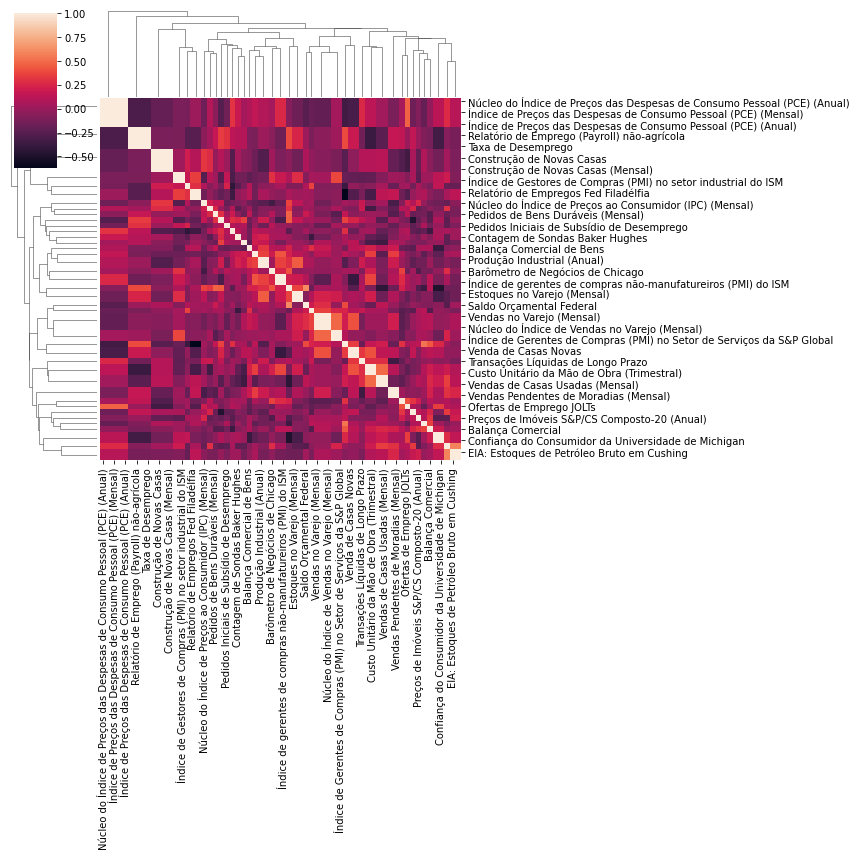

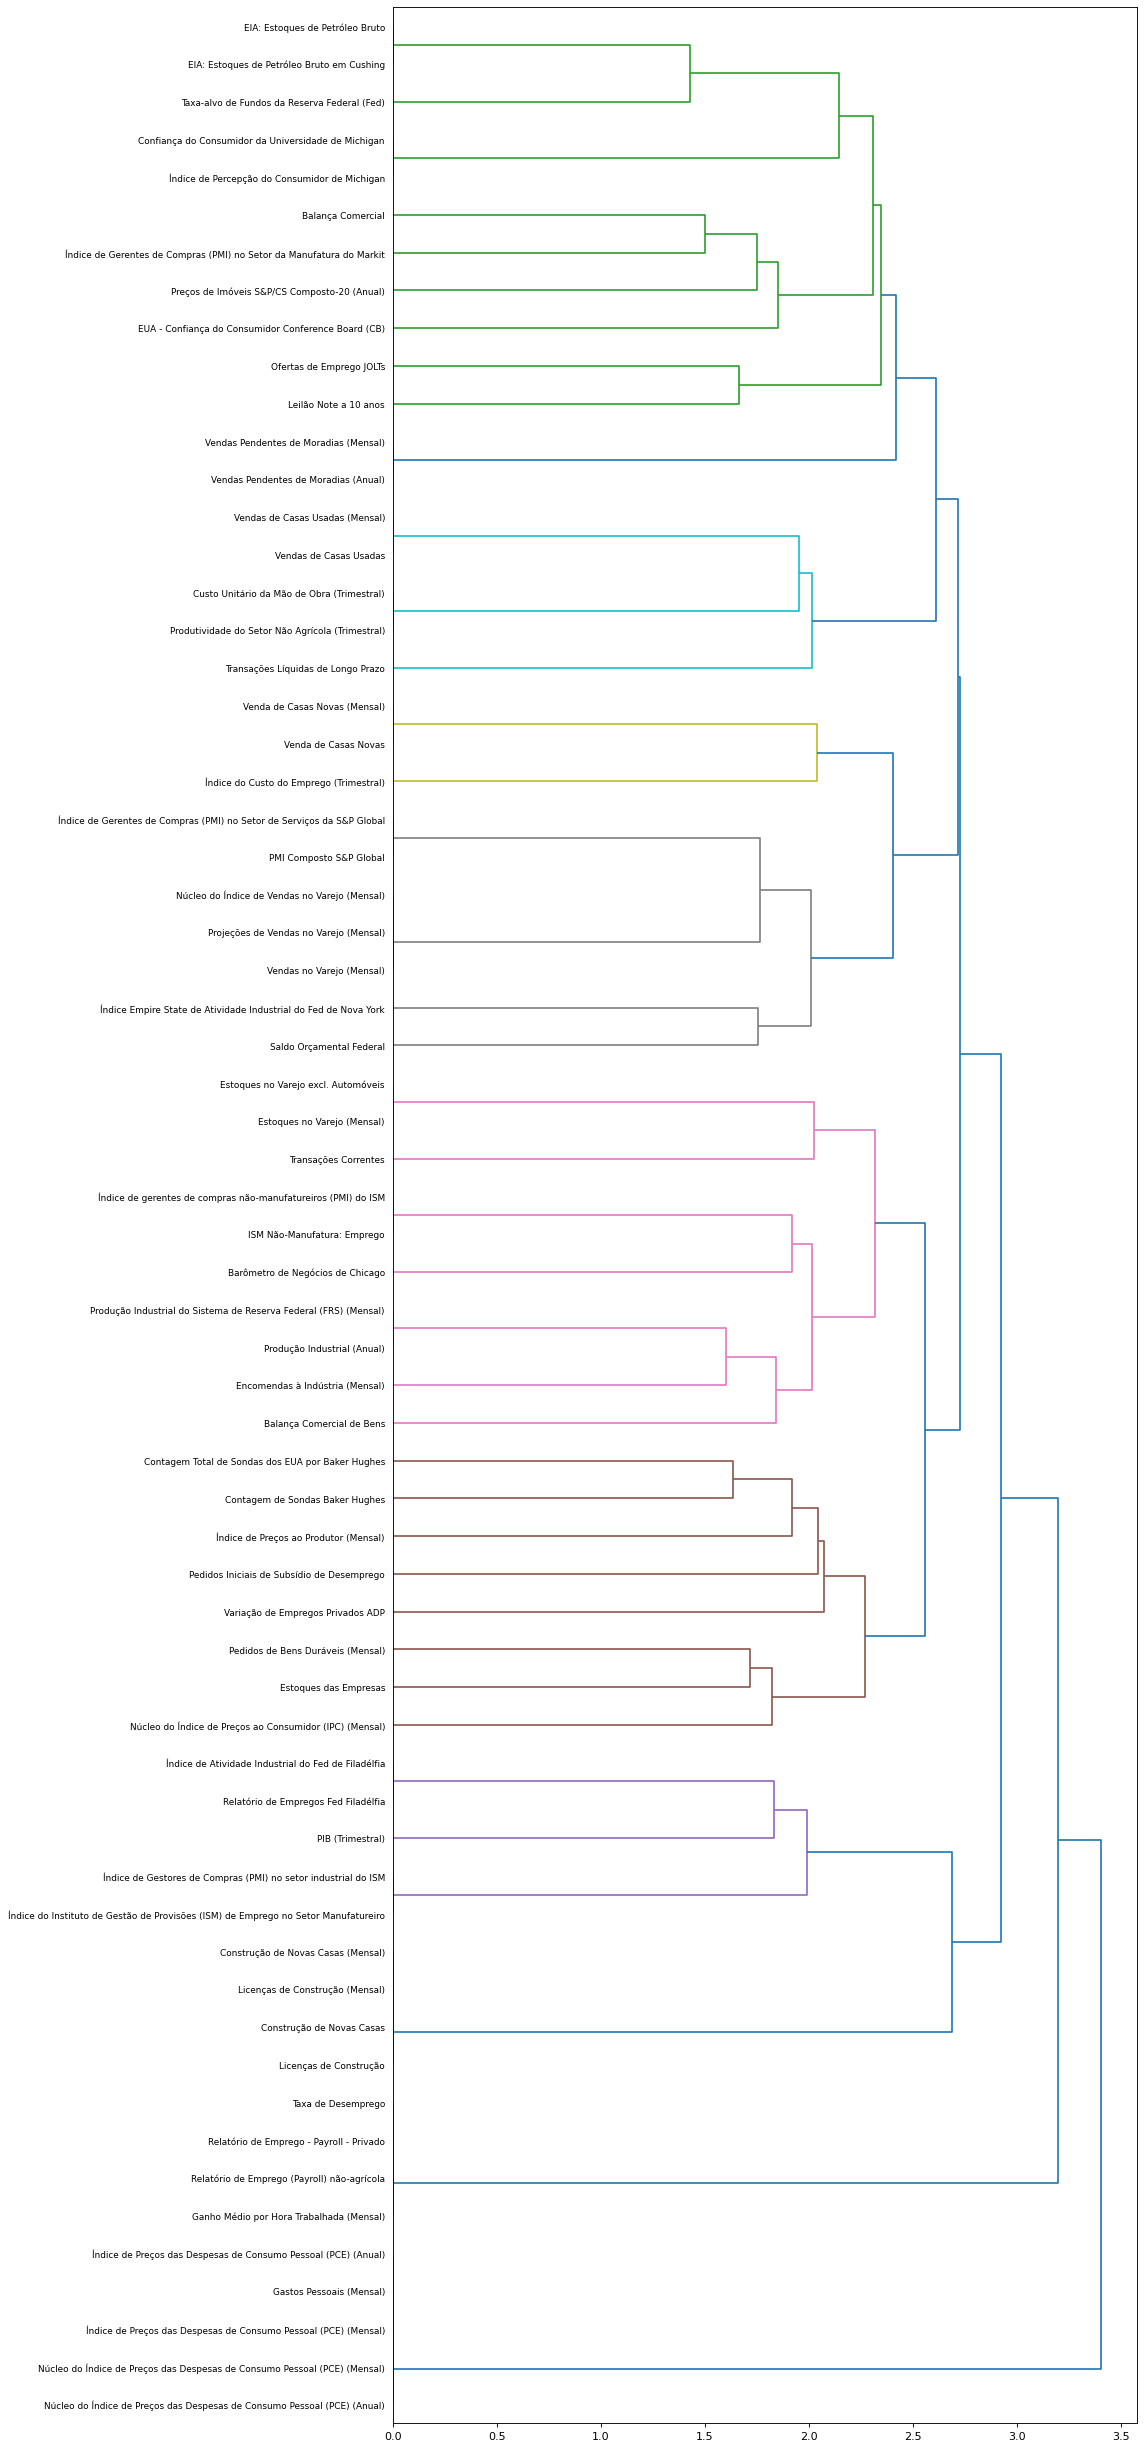

In [7]:
dfTrain = variationRatio(dfEventsData=dfEventsDataTrain,dfMarketData=dfMarketDataTrain)
dendTrain=cs.plot_heatmap_dendogram(dfTrain,'dend_train')

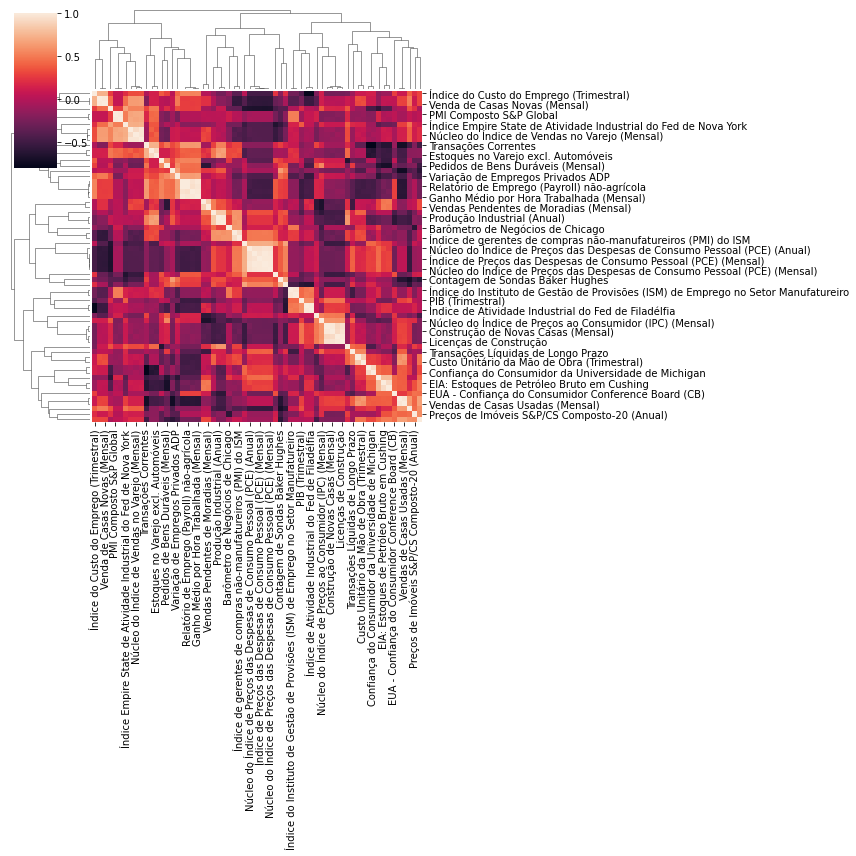

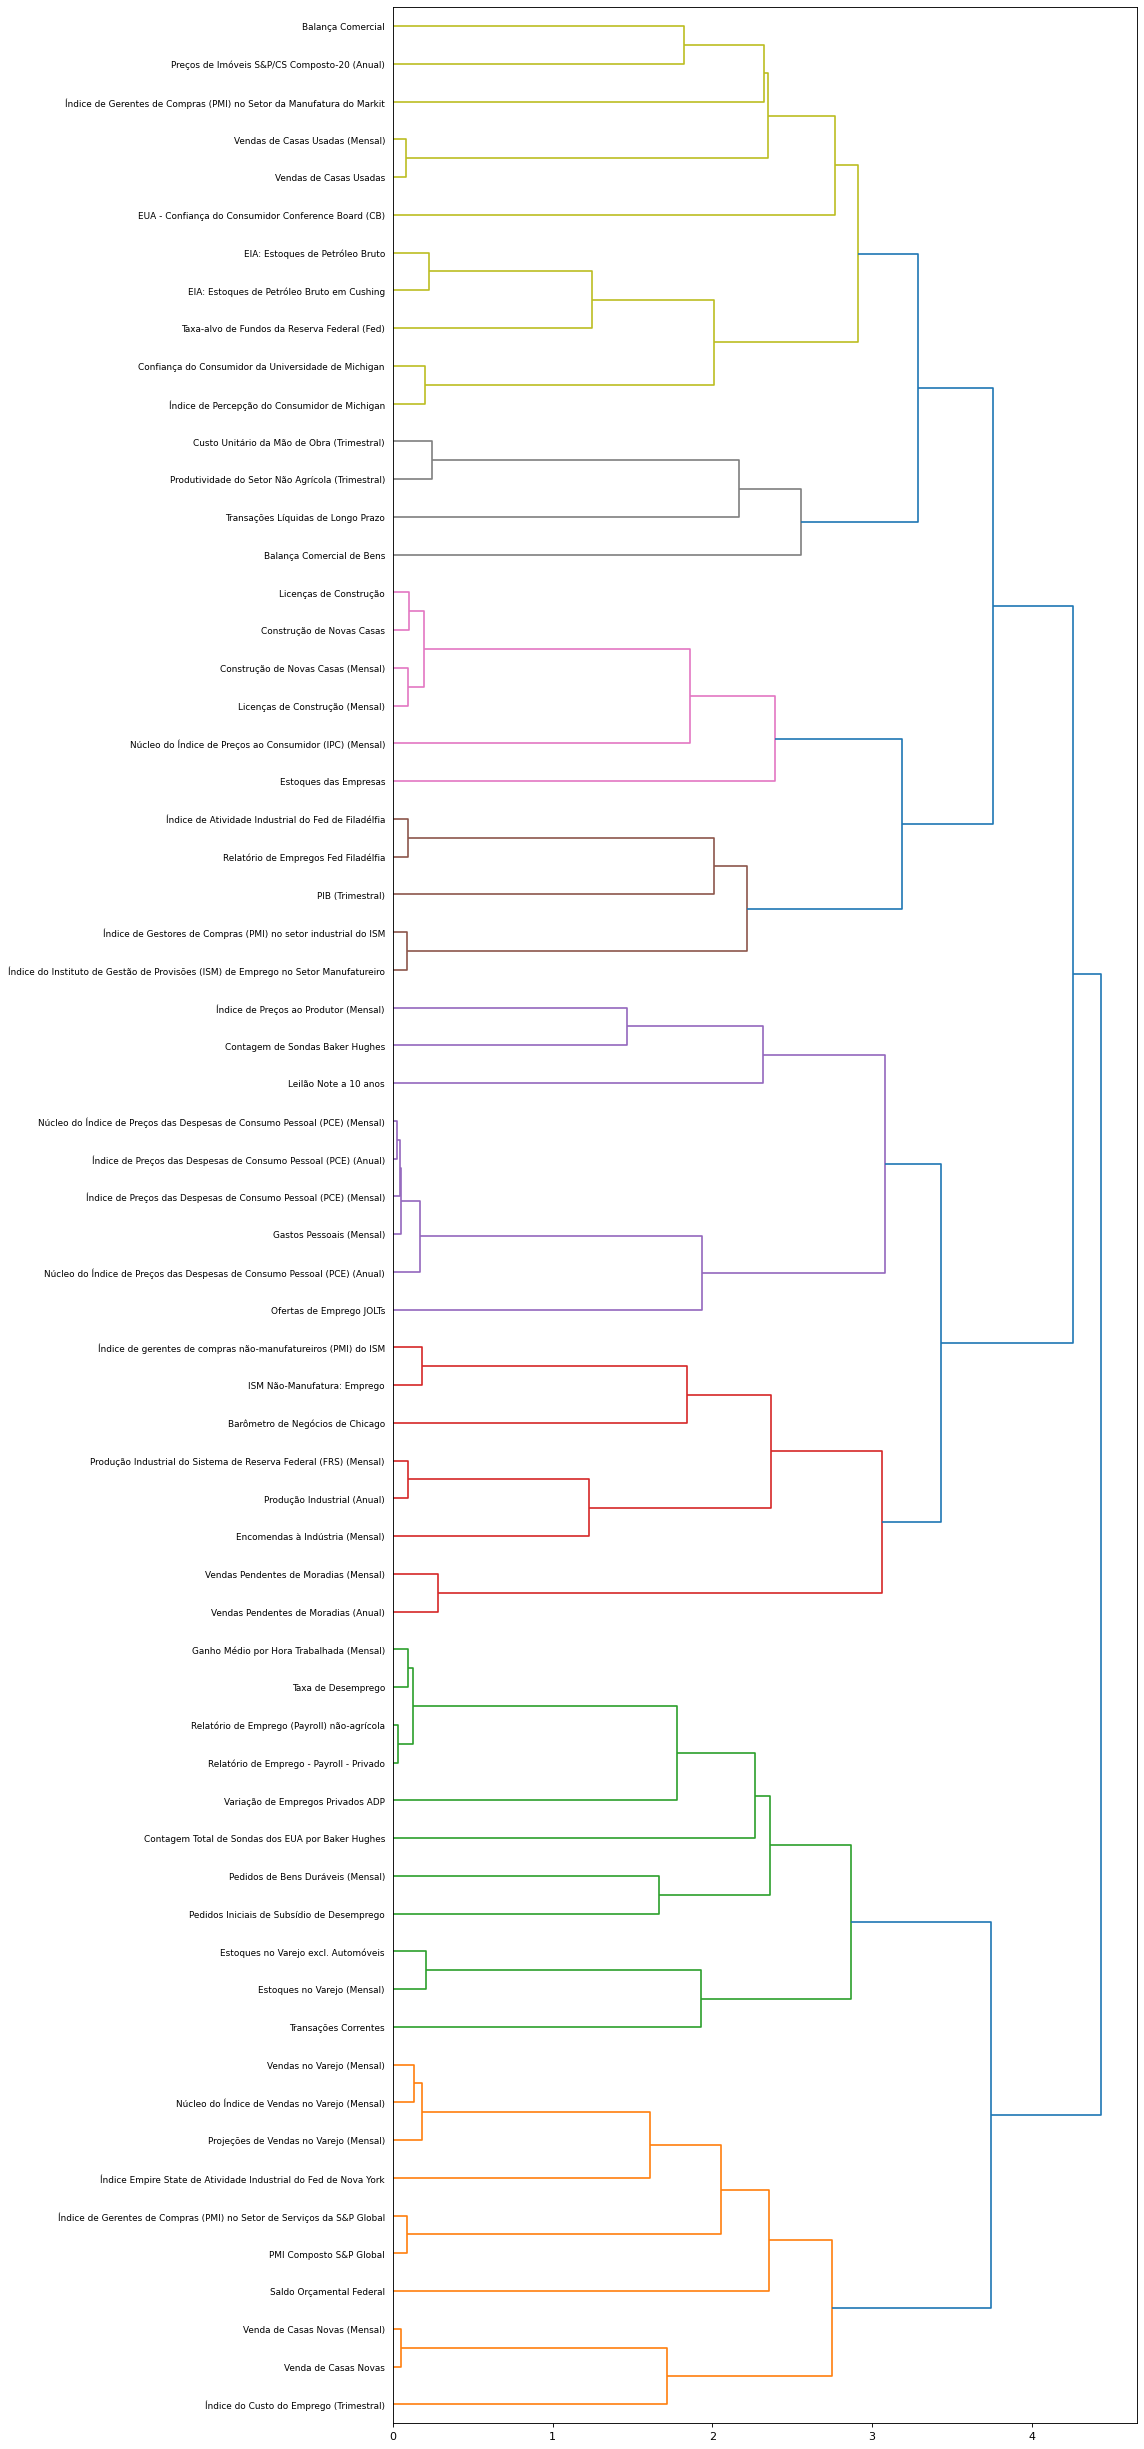

In [8]:
dfTrainDenoised = cs.cov2corr(cs.cleanMatrix(dfTrain))
dendTrainDenoised=cs.plot_heatmap_dendogram(dfTrainDenoised,'dend_train_denoised')

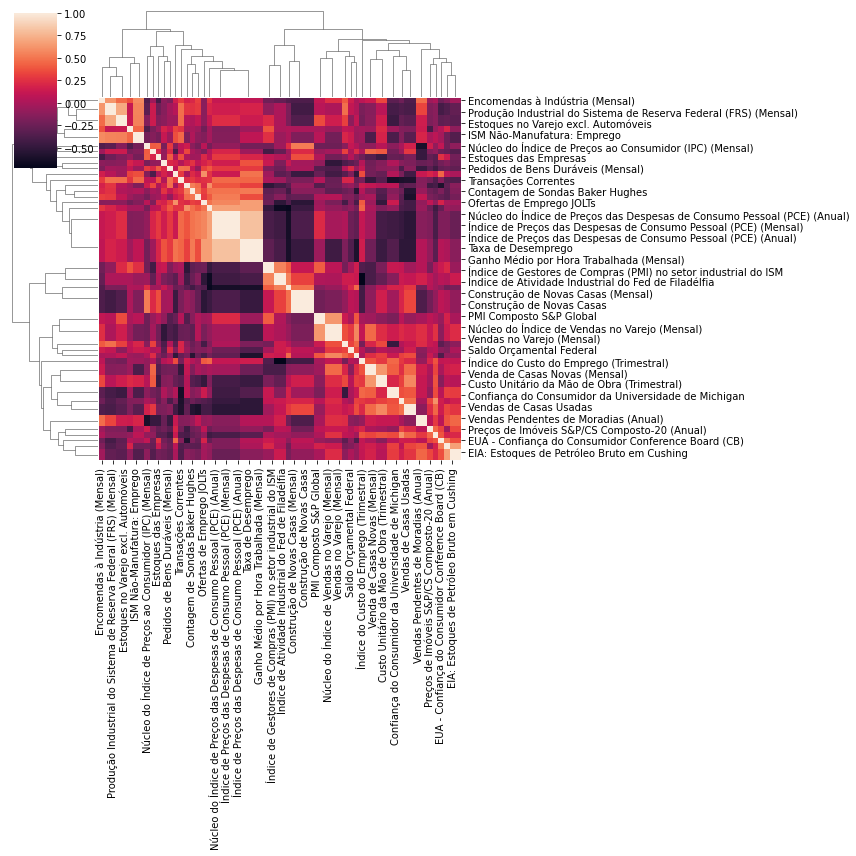

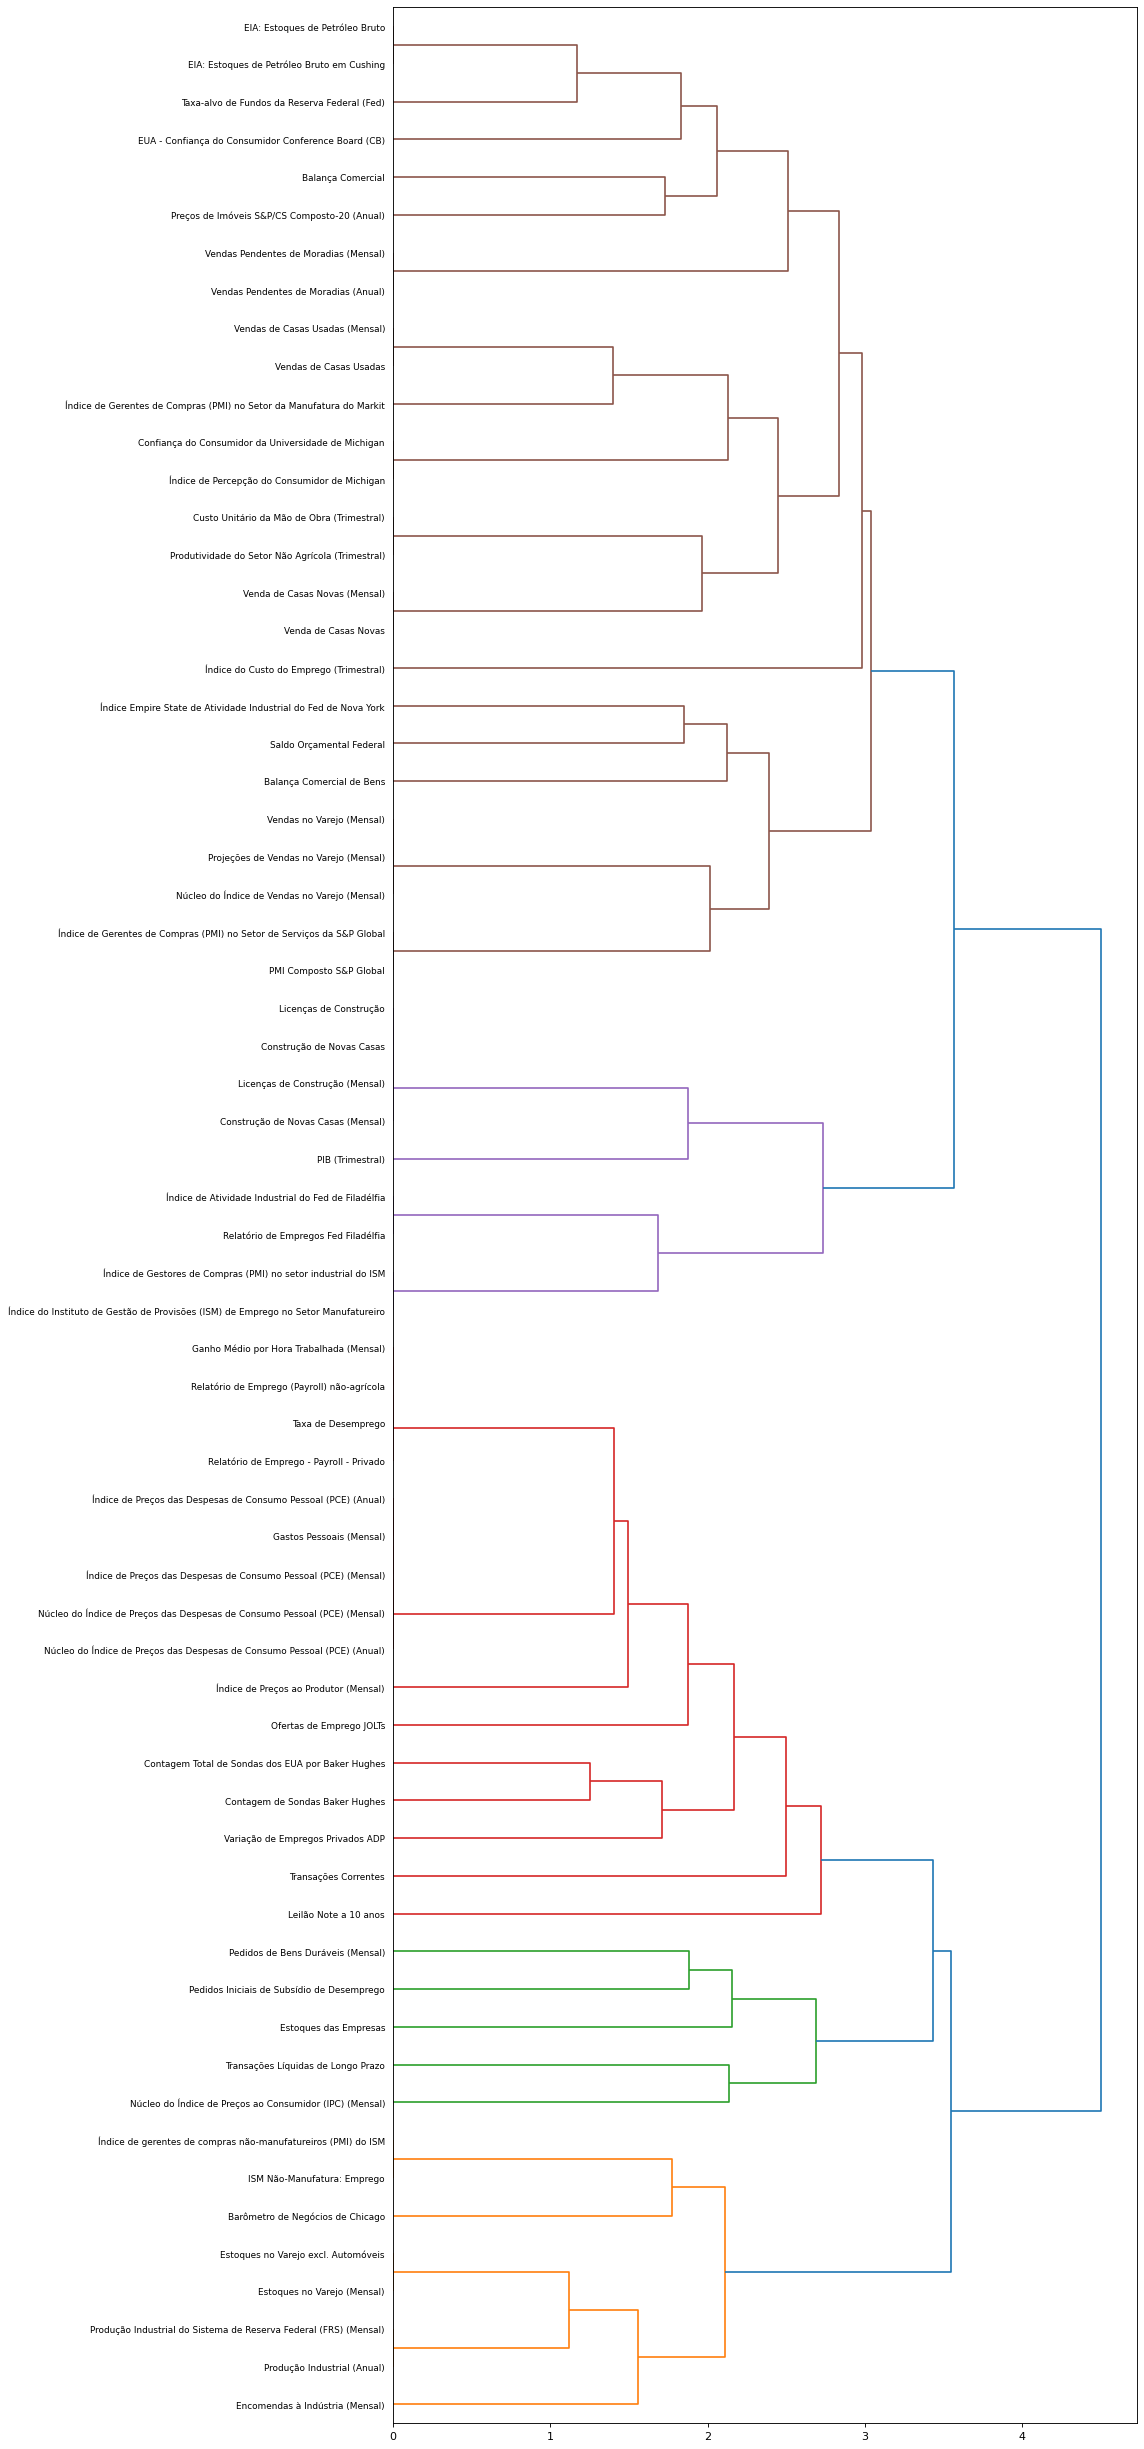

In [9]:
dfTrainDetoned = cs.cov2corr(cs.detonMatrix(dfTrain))
dendTrainDetoned=cs.plot_heatmap_dendogram(dfTrainDetoned,'dend_train_detoned')

In [10]:
chosenDend=dendTrainDenoised

In [11]:
dict_related = {}
idx_group = 1
for i in range(0,len(dendTrainDenoised['ivl'])):
    color = dendTrainDenoised['leaves_color_list'][i][-1]
    key = f'Group_{color}'
    if key in dict_related.keys():
        dict_related[key].append(dendTrainDenoised['ivl'][i])
    else:
        dict_related[key]=[dendTrainDenoised['ivl'][i]]

In [12]:
df_groups = pd.DataFrame.from_dict(dict_related, orient='index')
df_groups = df_groups.transpose()

In [13]:
df_groups

,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,Group_8
0,Índice do Custo do Emprego (Trimestral),Transações Correntes,Vendas Pendentes de Moradias (Anual),Ofertas de Emprego JOLTs,Índice do Instituto de Gestão de Provisões (IS...,Estoques das Empresas,Balança Comercial de Bens,Índice de Percepção do Consumidor de Michigan
1,Venda de Casas Novas,Estoques no Varejo (Mensal),Vendas Pendentes de Moradias (Mensal),Núcleo do Índice de Preços das Despesas de Con...,Índice de Gestores de Compras (PMI) no setor i...,Núcleo do Índice de Preços ao Consumidor (IPC)...,Transações Líquidas de Longo Prazo,Confiança do Consumidor da Universidade de Mic...
2,Venda de Casas Novas (Mensal),Estoques no Varejo excl. Automóveis,Encomendas à Indústria (Mensal),Gastos Pessoais (Mensal),PIB (Trimestral),Licenças de Construção (Mensal),Produtividade do Setor Não Agrícola (Trimestral),Taxa-alvo de Fundos da Reserva Federal (Fed)
3,Saldo Orçamental Federal,Pedidos Iniciais de Subsídio de Desemprego,Produção Industrial (Anual),Índice de Preços das Despesas de Consumo Pesso...,Relatório de Empregos Fed Filadélfia,Construção de Novas Casas (Mensal),Custo Unitário da Mão de Obra (Trimestral),EIA: Estoques de Petróleo Bruto em Cushing
4,PMI Composto S&P Global,Pedidos de Bens Duráveis (Mensal),Produção Industrial do Sistema de Reserva Fede...,Índice de Preços das Despesas de Consumo Pesso...,Índice de Atividade Industrial do Fed de Filad...,Construção de Novas Casas,None,EIA: Estoques de Petróleo Bruto
5,Índice de Gerentes de Compras (PMI) no Setor d...,Contagem Total de Sondas dos EUA por Baker Hughes,Barômetro de Negócios de Chicago,Núcleo do Índice de Preços das Despesas de Con...,None,Licenças de Construção,None,EUA - Confiança do Consumidor Conference Board...
6,Índice Empire State de Atividade Industrial do...,Variação de Empregos Privados ADP,ISM Não-Manufatura: Emprego,Leilão Note a 10 anos,None,None,None,Vendas de Casas Usadas
7,Projeções de Vendas no Varejo (Mensal),Relatório de Emprego - Payroll - Privado,Índice de gerentes de compras não-manufatureir...,Contagem de Sondas Baker Hughes,None,None,None,Vendas de Casas Usadas (Mensal)
8,Núcleo do Índice de Vendas no Varejo (Mensal),Relatório de Emprego (Payroll) não-agrícola,None,Índice de Preços ao Produtor (Mensal),None,None,None,Índice de Gerentes de Compras (PMI) no Setor d...
9,Vendas no Varejo (Mensal),Taxa de Desemprego,None,None,None,None,None,Preços de Imóveis S&P/CS Composto-20 (Anual)


# Estimate numbers

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def vif(X):
    
    # perform feature scaling
    scaler = StandardScaler()
    xs = scaler.fit_transform(X)
    
    # subsume into a dataframe
    vif = pd.DataFrame()
    vif["Features"] = X.columns
    vif["VIF Factor"] = [variance_inflation_factor(xs, i) for i in range(xs.shape[1])]
    
    return vif

In [26]:
dict_data = {}
for idx, data in dfEventsData.iterrows():
    if dfEventsFromTo[int(data['EventID'])]['EventName'] in dict_data.keys():
        dict_data[dfEventsFromTo[int(data['EventID'])]['EventName']].append(data['ActualValue'])
    else:
        dict_data[dfEventsFromTo[int(data['EventID'])]['EventName']]=[data['ActualValue']]
df = pd.DataFrame.from_dict(dict_data, orient='index')
df = df.transpose()
df.head()

,Relatório de Emprego - Payroll - Privado,Taxa de Desemprego,Relatório de Emprego (Payroll) não-agrícola,Ganho Médio por Hora Trabalhada (Mensal),Contagem de Sondas Baker Hughes,Contagem Total de Sondas dos EUA por Baker Hughes,Índice de Preços ao Produtor (Mensal),Núcleo do Índice de Preços ao Consumidor (IPC) (Mensal),EIA: Estoques de Petróleo Bruto em Cushing,EIA: Estoques de Petróleo Bruto,...,Índice do Instituto de Gestão de Provisões (ISM) de Emprego no Setor Manufatureiro,Variação de Empregos Privados ADP,Taxa-alvo de Fundos da Reserva Federal (Fed),Balança Comercial,Produtividade do Setor Não Agrícola (Trimestral),Custo Unitário da Mão de Obra (Trimestral),Encomendas à Indústria (Mensal),ISM Não-Manufatura: Emprego,Índice de gerentes de compras não-manufatureiros (PMI) do ISM,Transações Correntes
0,102000000.0,4100000.0,103000000.0,300000.0,808000000.0,1.003000e+09,300000.0,-100000.0,1129000.0,3306000.0,...,54200000.0,204000000.0,1750000.0,-48956000.0,700000.0,2700000.0,1600000.0,53600000.0,56800000.0,-124105000.0
1,168000000.0,3900000.0,164000000.0,100000.0,815000000.0,1.008000e+09,100000.0,200000.0,-1115000.0,-1071000.0,...,56300000.0,178000000.0,2000000.0,-46199000.0,400000.0,2900000.0,-800000.0,54100000.0,58600000.0,-101460000.0
2,218000000.0,3800000.0,223000000.0,300000.0,820000000.0,1.013000e+09,500000.0,100000.0,459000.0,2170000.0,...,56000000.0,177000000.0,2000000.0,-43053000.0,2900000.0,-900000.0,400000.0,53600000.0,59100000.0,-124817000.0
3,202000000.0,4000000.0,213000000.0,200000.0,825000000.0,1.021000e+09,300000.0,200000.0,416000.0,6218000.0,...,56500000.0,219000000.0,2250000.0,-46348000.0,2900000.0,-1000000.0,700000.0,56100000.0,55700000.0,-134377000.0
4,170000000.0,3900000.0,157000000.0,300000.0,834000000.0,1.032000e+09,0.0,200000.0,1388000.0,-2197000.0,...,58500000.0,163000000.0,2250000.0,-50082000.0,2200000.0,1200000.0,-800000.0,56700000.0,58500000.0,-130403000.0


In [250]:
df_group_to_study = df_groups
possible_columns = df_groups.columns[1]
label = df_groups[possible_columns][2]
X = df.drop([elem for i in df_groups.columns for elem in df_groups[i] if i not in [possible_columns] if elem != None], axis=1)
X = X.drop(label, axis=1)
y = df[label]
X = X.shift(-1)
X = X.dropna()
y = y.dropna()
min_len = min(len(X),len(y))
X = X.iloc[0:min_len]
y = y.iloc[0:min_len]

In [252]:
# Splitting the datasets into training and testing data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [257]:
result_vif_train=vif(X_train)[vif(X_train)['VIF Factor']<5]
result_vif_train=result_vif_train.reset_index(drop=True)
X = X[result_vif_train['Features']]
result_vif_train

,Features,VIF Factor
0,Taxa de Desemprego,2.219024
1,Ganho Médio por Hora Trabalhada (Mensal),1.143016
2,Contagem Total de Sondas dos EUA por Baker Hughes,1.880412
3,Estoques no Varejo (Mensal),2.643840
4,Pedidos de Bens Duráveis (Mensal),4.490568
5,Transações Correntes,3.442788


In [258]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

In [259]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

In [260]:
from sklearn.metrics import mean_squared_error

# fit/train model
pipe.fit(X_train, y_train)

# predict labels
y_pred = pipe.predict(X_test)

# metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'MSE: {mse:0.4}')
print(f'RMSE: {rmse:0.4}')
print(f'R^2 Train: {pipe.score(X_train, y_train):0.4}')
print(f'R^2 Test: {pipe.score(X_test, y_test):0.4}')

MSE: 6.013e+11
RMSE: 7.754e+05
R^2 Train: 0.8311
R^2 Test: -2.537


In [261]:
elastic = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', ElasticNet(alpha=0.1, l1_ratio=0.5))
])
# fit elasticnet model
elastic.fit(X_train, y_train)
print(f'R^2 Train: {elastic.score(X_train, y_train):0.4}')
print(f'R^2 Test: {elastic.score(X_test, y_test):0.4}')

R^2 Train: 0.8216
R^2 Test: -1.997
